In [24]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')

print("Modules Loaded")

Modules Loaded


In [25]:
import os
import cv2
import glob
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from pathlib import Path
import concurrent.futures
import keras.backend as K
from time import perf_counter
from functools import lru_cache
import matplotlib.pyplot as plt
from keras import layers, models
from keras.optimizers import Adam
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import accuracy_score, classification_report

In [26]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Preprocessing

#### Read data and store in df

In [27]:
def main(train_data_path):
    
    """
    return training and testing dataframes including 2 columns image path and its label
    
    Args:
      train_data_path (string): string includes your train data path
      test_data_path (string): string includes your test data path
      note: data_path argument must contains your classes dirs
      
    Returns:
      train_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the training images and the label of each image
      test_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the testing images and the label of each image

    """
    
    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)
        
        train_df = obtain_train_df(filepaths, labels)
        
            
    return train_df



def get_fileList(classes_list, dirs, filepaths, labels):
    
    
    """
    return file paths list including all full image paths and label for each one
    
    Args:
      classes_list (list): list includes name of classes dirs
      dirs (string): the data path
      filepaths (list): empty list to fill with images paths later
      labels (list): empty list to fill with each image label later
      
    Returns:
      count (scalar):  number of images in your dataset
    """
    
    
    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))
        
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)
        
    return filepaths, labels


def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    
    """
    return nothing, it fills the filepaths list with all the images paths and its labels
    
    Args:
      flist (list) : contains all the image names in certain class
      classes_list (list): list includes name of classes dirs
      filepaths (list): stores all the images paths
      labels (list): stores the label of each image in the dataset
      label (string): label for a specific image
      
    Returns:
      nothing
    """
    
    
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)



def obtain_train_df(filepaths, labels):
    
    """
    Return Dataframe with 2 columns contains each image path with its label
    
    Args:
      filepaths (list): stores all the images paths
      labels (list): stores the label of each image in the dataset
      
    Returns:
      train_df (DataFrame):  Dataframe with 2 columns contains each image path with its label
    """
    
    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

def merge_classes(data):
    """
    Merge classes with similar names
    
    Args:
      labels (list): list of image labels
      
    Returns:
      merged_labels (list): list of merged image labels
    """
    # Define mappings of classes to be merged
    class_mappings_reversed = {
    'Astrocitoma T1': 'Astrocitoma',
    'Astrocitoma T1C+': 'Astrocitoma',
    'Astrocitoma T2': 'Astrocitoma',
    'Carcinoma T1': 'Carcinoma',
    'Carcinoma T1C+': 'Carcinoma',
    'Carcinoma T2': 'Carcinoma',
    'Ependimoma T1': 'Ependimoma',
    'Ependimoma T1C+': 'Ependimoma',
    'Ependimoma T2': 'Ependimoma',
    'Ganglioglioma T1': 'Ganglioglioma',
    'Ganglioglioma T1C+': 'Ganglioglioma',
    'Ganglioglioma T2': 'Ganglioglioma',
    'Germinoma T1': 'Germinoma',
    'Germinoma T1C+': 'Germinoma',
    'Germinoma T2': 'Germinoma',
    'Glioblastoma T1': 'Glioblastoma',
    'Glioblastoma T1C+': 'Glioblastoma',
    'Glioblastoma T2': 'Glioblastoma',
    'Granuloma T1': 'Granuloma',
    'Granuloma T1C+': 'Granuloma',
    'Granuloma T2': 'Granuloma',
    'Meduloblastoma T1': 'Meduloblastoma',
    'Meduloblastoma T1C+': 'Meduloblastoma',
    'Meduloblastoma T2': 'Meduloblastoma',
    'Meningioma T1': 'Meningioma',
    'Meningioma T1C+': 'Meningioma',
    'Meningioma T2': 'Meningioma',
    'Neurocitoma T1': 'Neurocitoma',
    'Neurocitoma T1C+': 'Neurocitoma',
    'Neurocitoma T2': 'Neurocitoma',
    'Oligodendroglioma T1': 'Oligodendroglioma',
    'Oligodendroglioma T1C+': 'Oligodendroglioma',
    'Oligodendroglioma T2': 'Oligodendroglioma',
    'Papiloma T1': 'Papiloma',
    'Papiloma T1C+': 'Papiloma',
    'Papiloma T2': 'Papiloma',
    'Schwannoma T1': 'Schwannoma',
    'Schwannoma T1C+': 'Schwannoma',
    'Schwannoma T2': 'Schwannoma',
    'Tuberculoma T1': 'Tuberculoma',
    'Tuberculoma T1C+': 'Tuberculoma',
    'Tuberculoma T2': 'Tuberculoma',
    '_NORMAL T1': 'NORMAL',
    '_NORMAL T2': 'NORMAL'
}

    for i in data.index:
        data["label"].at[i] = class_mappings_reversed[data["label"].at[i]]
        
    return data

In [28]:
data_dir = "D://xtras//CNN//Brain Tumor//Dataset - 44 classes"

data_df = main(data_dir)


In [29]:
data_df.head()

,image_path,label
0,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Astrocitoma T1
1,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Astrocitoma T1
2,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Astrocitoma T1
3,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Astrocitoma T1
4,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Astrocitoma T1


In [30]:
data_df = merge_classes(data_df)


In [31]:
data_df["label"].unique()

array(['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma',
       'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma',
       'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma',
       'Schwannoma', 'Tuberculoma', 'NORMAL'], dtype=object)

In [32]:
num_classes = len(data_df['label'].unique())
print(f"We have {num_classes} classes")
print(f"We have {data_df.shape[0]} images")

We have 15 classes
We have 4479 images


In [33]:
num_classes = len(data_df['label'].value_counts())
data_df['label'].value_counts()
df = data_df


#### Split data into train, valid, test

In [34]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df['label'])

train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=42, stratify=train_df['label'])

In [35]:
train_df

,image_path,label
3889,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Tuberculoma
3573,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Schwannoma
117,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Astrocitoma
2519,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Neurocitoma
245,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Astrocitoma
...,...,...
1652,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Meningioma
4125,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,NORMAL
1017,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Ganglioglioma
1436,D://xtras//CNN//Brain Tumor//Dataset - 44 clas...,Meduloblastoma


#### ImageDataGenerator

In [36]:
BATCH_SIZE = 8
image_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='image_path', y_col='label', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=BATCH_SIZE)
train_steps = len(train_df) // BATCH_SIZE

valid_gen = gen.flow_from_dataframe(valid_df, x_col='image_path', y_col='label', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=BATCH_SIZE)
val_steps = len(valid_df) // BATCH_SIZE

test_gen = gen.flow_from_dataframe(test_df, x_col='image_path', y_col='label', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=BATCH_SIZE)
test_steps = len(test_df) // BATCH_SIZE


Found 2865 validated image filenames belonging to 15 classes.
Found 717 validated image filenames belonging to 15 classes.
Found 896 validated image filenames belonging to 15 classes.


### Model Structure

In [37]:
class AvgTwiceMaxPooling2D(layers.Layer):
    """
    Custom Keras layer that performs average - twice-maximum pooling on the input.

    Args:
        pool_size (int, optional): Pooling window size. Defaults to 2.
        strides (int, optional): Stride size for pooling. Defaults to 2.
        padding (str, optional): Padding mode ('same' or 'valid'). Defaults to 'same'.

    Returns:
        tf.Tensor: Output tensor after applying twice-maximum average pooling.
    """
    def __init__(self, pool_size=2, strides=2, padding='same', **kwargs):
        super(AvgTwiceMaxPooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    @tf.function
    def call(self, inputs, **kwargs):
        """
        Apply the average - twice-maximum pooling operation to the input tensor.

        Args:
            inputs (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Output tensor after applying twice-maximum average pooling.
            :param **kwargs:
        """
        # Apply max pooling and average pooling
        max_pooled = layers.MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding=self.padding)(inputs)
        avg_pooled = layers.AveragePooling2D(pool_size=self.pool_size, strides=self.strides, padding=self.padding)(inputs)

        # Apply the average - twice-maximum pooling operation
        output = tf.subtract(avg_pooled, tf.add(max_pooled, max_pooled))
        return output

In [38]:
from tensorflow.keras.layers import LeakyReLU
def create_brian_tumor_model(input_shape, n_classes):
    """
    Create a convolutional neural network model optimized for image classification.

    Args:
        input_shape (tuple): Shape of input images (height, width, channels).
        n_classes (int): Number of classes for classification.

    Returns:
        tf.keras.Model: Created CNN model.
    """
    model_name = 'MRINet'

    input_layer = layers.Input(shape=input_shape, name='Input')

    blk1 = layers.Conv2D(21, kernel_size=3, strides=1, padding='same', activation='relu', name='Conv1')(input_layer)
    blk1 = layers.BatchNormalization()(blk1)
    blk1 = layers.MaxPooling2D(strides=2, name='MaxPool1')(blk1)

    blk2 = layers.Conv2D(34, kernel_size=3, strides=1, padding='same', activation='relu', name='Conv2')(blk1)
    blk2 = layers.BatchNormalization()(blk2)
    blk2 = layers.MaxPooling2D(strides=2, name='MaxPool2')(blk2)

    avgtwicemax = AvgTwiceMaxPooling2D(pool_size=(3, 3))(blk2)

    blk3 = layers.Conv2D(55, kernel_size=3, strides=1, padding='same', activation='relu', name='Conv3')(blk2)
    blk3 = layers.MaxPooling2D(strides=2, name='MaxPool3')(blk3) 
    norm = layers.BatchNormalization()(blk3) 

    concat = layers.Concatenate(name="VerticalConcat2")([norm, avgtwicemax])

    # concat from 3 to 5
    blk = layers.Conv2D(24, kernel_size=3, strides=1, padding='same', activation='relu', name='ConvC')(norm)
    blk = layers.BatchNormalization()(blk)
    blk = AvgTwiceMaxPooling2D(pool_size=(3, 3))(blk)


    blk4 = layers.Conv2D(89, kernel_size=3, padding='same', activation='relu', name='Conv4')(concat)
    blk4 = layers.BatchNormalization()(blk4) 
    blk4 = layers.MaxPooling2D(strides=2, name='MaxPool4')(blk4)

    concat2 = layers.Concatenate(name="VerticalConcat3")([blk4, blk])
    # added block 5
    blk5 = layers.Conv2D(144, kernel_size=3, padding='same', activation='relu', name='Conv5')(concat2)
    blk5 = layers.BatchNormalization()(blk5) 
    blk5 = layers.MaxPooling2D(strides=2, name='MaxPool5')(blk5)

    # added block 6
    blk6 = layers.Conv2D(233, kernel_size=3, padding='same',  activation="relu", name='Conv7')(blk5)
    blk6 = layers.DepthwiseConv2D(depth_multiplier=1, kernel_size=(3, 3), padding='same', activation="relu", name='DConv4')(blk6)
    blk6 = layers.BatchNormalization()(blk6) 

    # added block 7
    blk7 = layers.Conv2D(377, kernel_size=3, padding='same',  activation=LeakyReLU(alpha=0.01), name='Conv8')(blk6)
    blk7 = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding='same', activation="relu", name='DConv5')(blk7)
    blk7 = layers.BatchNormalization()(blk7) 

    gap = layers.GlobalAveragePooling2D(name='GAP')(blk7)

    output = layers.Dense(n_classes, activation='softmax', name='Output')(gap)

    model = tf.keras.Model(inputs=input_layer, outputs=output, name=model_name)
    return model

In [39]:
num_classes

15

In [40]:
input_shape = (224, 224, 3)
model = create_brian_tumor_model(input_shape, num_classes)
model.summary()

Model: "MRINet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 224, 21  588         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 224, 224, 21  84         ['Conv1[0][0]']                  
 rmalization)                   )                                                            

In [41]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [42]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [43]:
model.compile(
    optimizer = Adam(learning_rate = 5e-4),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy", create_metrics()]
)

In [44]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs=None):
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        """Calculate total training time."""
        self.total_train_time = time.perf_counter() - self.train_start_time

# Create an instance of the TimeCallback
time_callback = TimeCallback()

In [45]:
#@title Learning rate scheduler

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch,lr):
    if epoch < 13:
        return lr
    else:
        return 0.9*lr


lr_scheduler = LearningRateScheduler(lr_schedule)


In [46]:
TOTAL_EPOCHS = 25
start_time = perf_counter()
history = model.fit(
    train_gen,
    epochs=TOTAL_EPOCHS,
    validation_data=valid_gen,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[time_callback,lr_scheduler]
)
end_time = perf_counter()

Epoch 1/25
358/358 [==============================] - 68s 184ms/step - loss: 1.8308 - accuracy: 0.4291 - precision_1: 0.7159 - recall_1: 0.2037 - f1_score: 0.2858 - specificity: 0.9942 - sensitivity: 0.2032 - mcc: 0.3116 - auc_1: 0.8587 - val_loss: 2.1347 - val_accuracy: 0.2149 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_specificity: 1.0000 - val_sensitivity: 0.0000e+00 - val_mcc: 0.0000e+00 - val_auc_1: 0.8345 - lr: 5.0000e-04
Epoch 2/25
358/358 [==============================] - 12s 33ms/step - loss: 1.0552 - accuracy: 0.6713 - precision_1: 0.8250 - recall_1: 0.5296 - f1_score: 0.6294 - specificity: 0.9920 - sensitivity: 0.5283 - mcc: 0.6330 - auc_1: 0.9568 - val_loss: 0.7511 - val_accuracy: 0.7626 - val_precision_1: 0.8970 - val_recall_1: 0.6728 - val_f1_score: 0.7607 - val_specificity: 0.9945 - val_sensitivity: 0.6728 - val_mcc: 0.7606 - val_auc_1: 0.9761 - lr: 5.0000e-04
Epoch 3/25
358/358 [==============================] - 12s 33ms/st

In [47]:
execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(time_callback.total_train_time // unit[0])
    avg_value = int(np.mean(time_callback.epoch_times) // unit[0])

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    time_callback.total_train_time -= total_value * unit[0]
    time_callback.epoch_times = [time - avg_value * unit[0] for time in time_callback.epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

Model training took 05 minutes, 55 seconds, 181 milliseconds
Average time per epoch: 14 seconds, 188 milliseconds


In [48]:
_ = model.evaluate(test_gen, steps = test_steps)

112/112 [==============================] - 16s 141ms/step - loss: 0.2268 - accuracy: 0.9554 - precision_1: 0.9573 - recall_1: 0.9498 - f1_score: 0.9532 - specificity: 0.9970 - sensitivity: 0.9498 - mcc: 0.9500 - auc_1: 0.9910


In [49]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

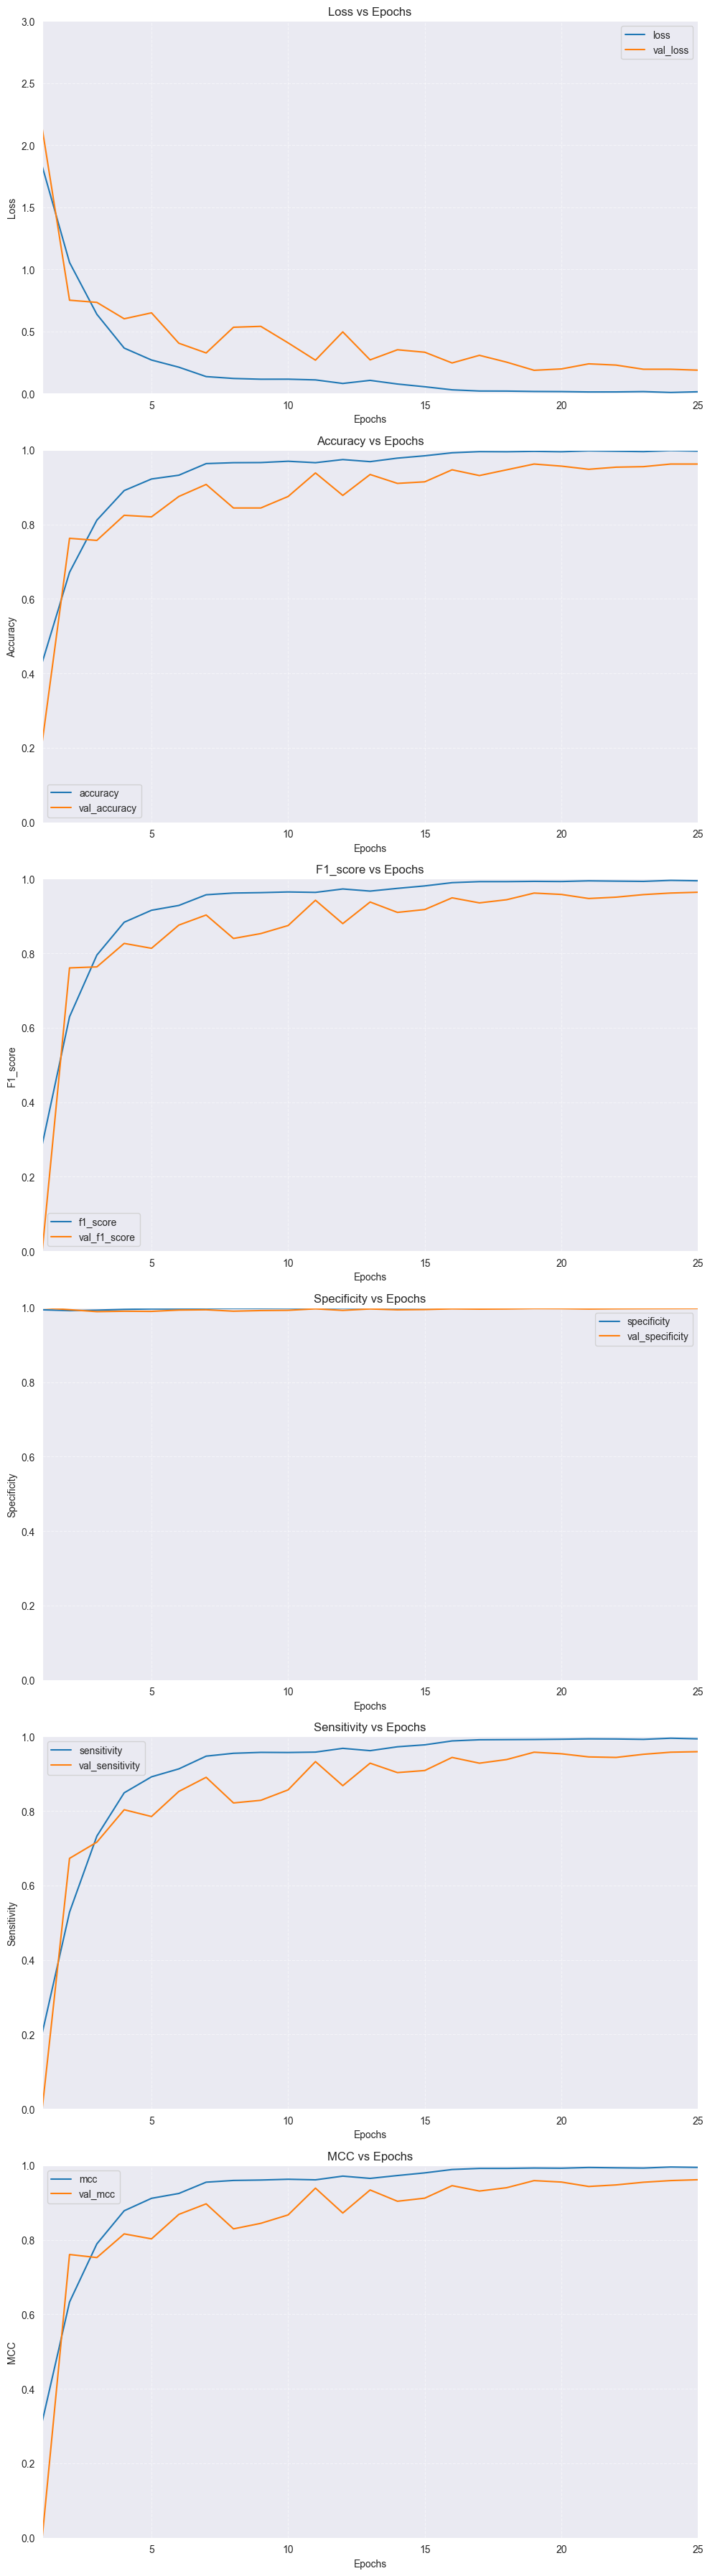

In [50]:
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)

In [51]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [52]:
true_labels, predicted_labels = generate_classification_report(
    model, test_gen, test_steps, BATCH_SIZE, df["label"].unique()
)

                   precision    recall  f1-score   support

      Astrocitoma     0.9407    0.9569    0.9487       116
        Carcinoma     0.9804    1.0000    0.9901        50
       Ependimoma     0.9310    0.9000    0.9153        30
    Ganglioglioma     0.8462    0.9167    0.8800        12
        Germinoma     0.8571    0.9000    0.8780        20
     Glioblastoma     1.0000    0.9756    0.9877        41
        Granuloma     0.8667    0.8125    0.8387        16
   Meduloblastoma     1.0000    0.9231    0.9600        26
       Meningioma     0.9659    0.9714    0.9687       175
      Neurocitoma     0.9292    1.0000    0.9633       105
Oligodendroglioma     0.9419    0.8901    0.9153        91
         Papiloma     0.9783    1.0000    0.9890        45
       Schwannoma     0.9783    0.9574    0.9677        47
      Tuberculoma     0.9778    0.9462    0.9617        93
           NORMAL     1.0000    0.9655    0.9825        29

         accuracy                         0.9554      

In [53]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (list or numpy.ndarray): Array-like object of true labels.
        predicted_labels (list or numpy.ndarray): Array-like object of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

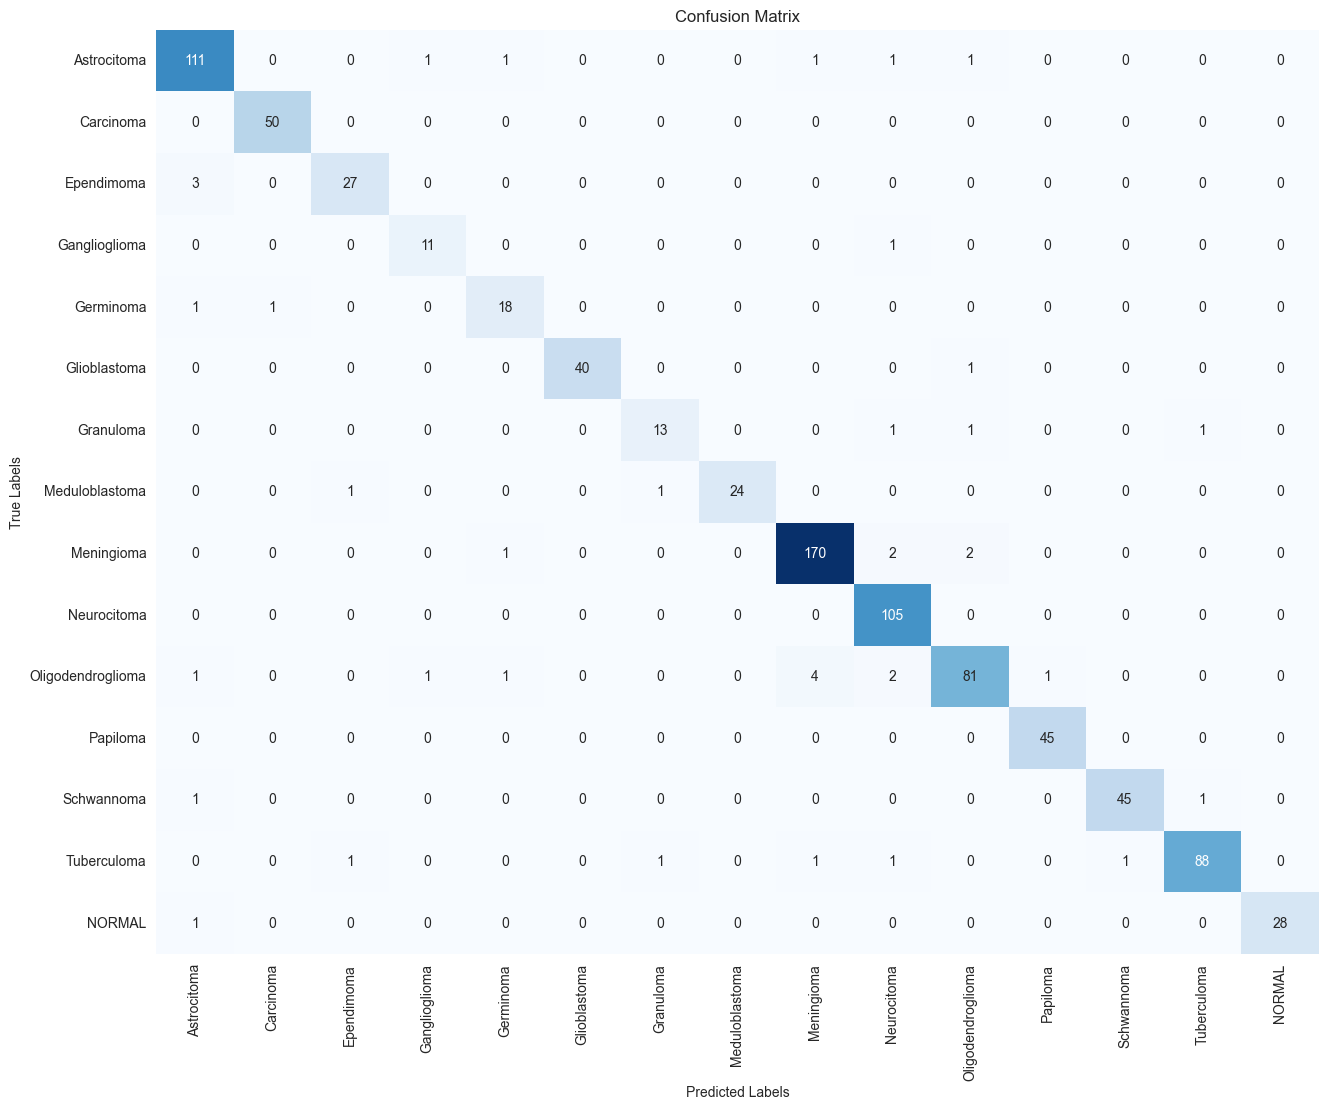

In [54]:
cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels= df["label"].unique(), yticklabels= df["label"].unique())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()